In [43]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
pid_file = 'PID_Schedule_Job_20220509.xls'
prweb_file = 'New Production Status Summary 2022-05-18.xlsx'
cft_list_file = 'CFTListExport_2022-05-20-09-10-10-246.xls'

Load PID_Schedule from Andy Wei

In [53]:
pid = pd.read_excel(pid_file, sheet_name='1_PID_Date', header=1, usecols=[2,3,4,5])

In [55]:
# Remove whole schedule rows
# Select PDP project
# Remove Asia SKU
pid = pid[(pid['Phase Name']!='Whole Schedule') & (pid['Project type']=='PDP') & (~pid['Project Name'].str.contains('Asia|ASIA'))]

In [56]:
# Replace . in Phase start column and covert to datetime
pid.loc[:,'Phase Start'] = pd.to_datetime(pid['Phase Start'].apply(lambda date : np.nan if date == '.' else str(date)), format='%Y%m%d')

In [40]:
# Replace . in Phase start column
#pid.loc[:,'Phase Start'] = pid['Phase Start'].apply(lambda date : np.nan if date == '.' else str(date))

In [50]:
#pid.loc[:,'Phase Start'] = pd.to_datetime(pid['Phase Start'], format='%Y%m%d')

In [57]:
pid = pid.dropna()

In [58]:
pid

,Project type,Project Name,Phase Name,Phase Start
2,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19
3,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04
4,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25
16,PDP,All_Garmin_meter,Mass Production,2022-05-30
18,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12
...,...,...,...,...
714,PDP,zumo XT2,TopLevelDesign,2021-12-16
715,PDP,zumo XT2,Working Proto,2022-05-11
716,PDP,zumo XT2,Factory Proto,2022-08-26
717,PDP,zumo XT2,Pilot Run,2022-11-21


Loda CFT data from PM system

In [70]:
cft = pd.read_excel(cft_list_file, usecols=[0,1,44])

In [71]:
cft.rename(columns={"Develop  Product QE (DPQE)":"DPQE"}, inplace=True)

Find Mismatch between PID_schedule and PM system

In [72]:
mismatch = pd.merge(how='left',left=pid, right=cft, on='Project Name')

In [73]:
# Find projects didn't have DPQE in PM system
mismatch[mismatch['DPQE'].isnull()]['Project Name'].drop_duplicates()

3              All_Garmin_meter
11                 Approach S70
55     Cellular Tracking Module
111       EPIX PRO (Gen 2) 47mm
116       EPIX PRO (Gen 2) 51mm
182                       GSD28
197           Instinct 2X Solar
246          Online Map Service
Name: Project Name, dtype: object

Merge PID_schedule and CFT (DPQE) info

In [74]:
pid_cft = pd.merge(left=pid, right=cft, on='Project Name')

In [75]:
# Weight socre, Toplevel, WP, MP = 1, FP = 2, PR = 3
pid_cft['weighted_score'] = pid_cft['Phase Name'].apply(lambda phase : 1 if (phase == 'Working Proto') | (phase == 'TopLevelDesign') | (phase == 'Mass Production') else 2 if phase=='Factory Proto' else 3 if phase=='Pilot Run' else 0)

In [76]:
pid_cft

,Project type,Project Name,Phase Name,Phase Start,Project ID,DPQE,weighted_score
0,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,15907,"Fu, Ernest",2
1,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,15907,"Fu, Ernest",3
2,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,15907,"Fu, Ernest",1
3,PDP,All_Garmin_meter,Mass Production,2022-05-30,14764,NaN,1
4,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,7029,"Kuo, Chris",1
...,...,...,...,...,...,...,...
367,PDP,zumo XT2,TopLevelDesign,2021-12-16,16069,"Ni, Wendy",1
368,PDP,zumo XT2,Working Proto,2022-05-11,16069,"Ni, Wendy",1
369,PDP,zumo XT2,Factory Proto,2022-08-26,16069,"Ni, Wendy",2
370,PDP,zumo XT2,Pilot Run,2022-11-21,16069,"Ni, Wendy",3


In [96]:
pid_cft.columns

Index(['Project type', 'Project Name', 'Phase Name', 'Phase Start',
       'Project ID', 'DPQE', 'weighted_score'],
      dtype='object')

Load "New Production Status Summary" to handle multi-projects in PRweb but share same project name in PMsystem and PID_schedule

In [87]:
prweb = pd.read_excel(prweb_file, header=1, usecols=[0,1,2,3])

In [88]:
prweb

,Project Name,Project Id,PM Project Name,PM Project Id
0,Xero B60i Laser Navigation Binoculars,1119,Xero B60i Laser Navigation Binoculars,13229
1,LED Control Module,1066,LED Control Module,13134
2,Descent Mk3 Series - Small,1058,Descent Mk3 Series,12994
3,Descent Mk3 Series - Large,1057,Descent Mk3 Series,12994
4,IMWW23,1084,IMWW23,14434
...,...,...,...,...
152,"Product - 1.3\"" GTR/GNC",984,"Product - 1.3\"" GTR/GNC",12164
153,eTrex Solar,1065,eTrex Solar,10901
154,Pet Tracker,944,Pet Tracker,10666
155,DGCN20,785,DGCN20,10620


In [93]:
multi_project = prweb.groupby(['PM Project Id','PM Project Name']).count()['Project Name'].sort_values(ascending=False).reset_index().rename(columns={'Project Name':'Multi_Projects_in_PRweb'})
multi_project = multi_project[multi_project['Multi_Projects_in_PRweb']>1]
multi_project

,PM Project Id,PM Project Name,Multi_Projects_in_PRweb
0,9946,GPSMAP 9000,5
1,15861,dezl OTR Series 2022,4
2,10718,BMW MGU22,4
3,15624,Catalyst Kart/Moto/Roadster,3
4,15969,RV/Camper 2022,3
5,13095,ECHOMAP UHD2 (Touch),3
6,10340,TXTW22_Drive+3.0 (Lawrence DA & Taroko EB),2
7,12994,Descent Mk3 Series,2
8,14529,Forerunner 265,2
9,13094,ECHOMAP UHD2 (Keyed),2


In [98]:
pid_cft_multi = pd.merge(how='left', left=pid_cft, right=multi_project, left_on='Project ID',right_on='PM Project Id')
pid_cft_multi['Multi_Projects_in_PRweb'].fillna(1, inplace=True)
pid_cft_multi

,Project type,Project Name,Phase Name,Phase Start,Project ID,DPQE,weighted_score,PM Project Id,PM Project Name,Multi_Projects_in_PRweb
0,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,15907,"Fu, Ernest",2,NaN,NaN,1.0
1,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,15907,"Fu, Ernest",3,NaN,NaN,1.0
2,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,15907,"Fu, Ernest",1,NaN,NaN,1.0
3,PDP,All_Garmin_meter,Mass Production,2022-05-30,14764,NaN,1,NaN,NaN,1.0
4,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,7029,"Kuo, Chris",1,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
367,PDP,zumo XT2,TopLevelDesign,2021-12-16,16069,"Ni, Wendy",1,NaN,NaN,1.0
368,PDP,zumo XT2,Working Proto,2022-05-11,16069,"Ni, Wendy",1,NaN,NaN,1.0
369,PDP,zumo XT2,Factory Proto,2022-08-26,16069,"Ni, Wendy",2,NaN,NaN,1.0
370,PDP,zumo XT2,Pilot Run,2022-11-21,16069,"Ni, Wendy",3,NaN,NaN,1.0


In [101]:
pid_cft_multi[pid_cft_multi['Multi_Projects_in_PRweb']>1]

,Project type,Project Name,Phase Name,Phase Start,Project ID,DPQE,weighted_score,PM Project Id,PM Project Name,Multi_Projects_in_PRweb
32,PDP,BMW MGU22,Mass Production,2022-05-02,10718,"Chen, Tiffany(QA);\nKelly, Joan;\nBruns, Melan...",1,10718.0,BMW MGU22,4.0
50,PDP,Catalyst Kart/Moto/Roadster,TopLevelDesign,2021-11-19,15624,"Lo, Aalto",1,15624.0,Catalyst Kart/Moto/Roadster,3.0
51,PDP,Catalyst Kart/Moto/Roadster,Working Proto,2022-06-24,15624,"Lo, Aalto",1,15624.0,Catalyst Kart/Moto/Roadster,3.0
52,PDP,Catalyst Kart/Moto/Roadster,Factory Proto,2022-10-10,15624,"Lo, Aalto",2,15624.0,Catalyst Kart/Moto/Roadster,3.0
53,PDP,Catalyst Kart/Moto/Roadster,Pilot Run,2022-12-29,15624,"Lo, Aalto",3,15624.0,Catalyst Kart/Moto/Roadster,3.0
54,PDP,Catalyst Kart/Moto/Roadster,Mass Production,2023-03-06,15624,"Lo, Aalto",1,15624.0,Catalyst Kart/Moto/Roadster,3.0
76,PDP,Descent Mk3,TopLevelDesign,2021-09-10,12994,"Wang, Cooper",1,12994.0,Descent Mk3 Series,2.0
77,PDP,Descent Mk3,Working Proto,2022-12-05,12994,"Wang, Cooper",1,12994.0,Descent Mk3 Series,2.0
78,PDP,Descent Mk3,Factory Proto,2023-05-05,12994,"Wang, Cooper",2,12994.0,Descent Mk3 Series,2.0
79,PDP,Descent Mk3,Pilot Run,2023-08-04,12994,"Wang, Cooper",3,12994.0,Descent Mk3 Series,2.0


In [41]:
#pid_cft_multi = pd.merge(how='left', left=pid_cft, right=multi_project, left_on='Project Name', right_on='PM Project Name')
#pid_cft_multi['Project counts'].fillna(1, inplace=True)
#pid_cft_multi


,Category,Project type,Project Name,Phase Name,Phase Start,DPQE,weighted_score,PM Project Name,Project counts
0,Fitness,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,"Fu, Ernest",2,NaN,1.0
1,Fitness,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,"Fu, Ernest",3,NaN,1.0
2,Fitness,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,"Fu, Ernest",1,NaN,1.0
3,OEM Auto,PDP,All_Garmin_meter,Mass Production,2022-05-30,NaN,1,NaN,1.0
4,Outdoor,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,"Kuo, Chris",1,NaN,1.0
...,...,...,...,...,...,...,...,...,...
367,Automotive,PDP,zumo XT2,TopLevelDesign,2021-12-16,"Ni, Wendy",1,NaN,1.0
368,Automotive,PDP,zumo XT2,Working Proto,2022-05-11,"Ni, Wendy",1,NaN,1.0
369,Automotive,PDP,zumo XT2,Factory Proto,2022-08-26,"Ni, Wendy",2,NaN,1.0
370,Automotive,PDP,zumo XT2,Pilot Run,2022-11-21,"Ni, Wendy",3,NaN,1.0


In [102]:
pid_cft_multi['weighted_score_multi projects'] = pid_cft_multi['weighted_score']*pid_cft_multi['Multi_Projects_in_PRweb']

In [103]:
pid_cft_multi

,Project type,Project Name,Phase Name,Phase Start,Project ID,DPQE,weighted_score,PM Project Id,PM Project Name,Multi_Projects_in_PRweb,weighted_score_multi projects
0,PDP,2022 vivofit jr. 3 SKUs,Factory Proto,2022-01-19,15907,"Fu, Ernest",2,NaN,NaN,1.0,2.0
1,PDP,2022 vivofit jr. 3 SKUs,Pilot Run,2022-03-04,15907,"Fu, Ernest",3,NaN,NaN,1.0,3.0
2,PDP,2022 vivofit jr. 3 SKUs,Mass Production,2022-04-25,15907,"Fu, Ernest",1,NaN,NaN,1.0,1.0
3,PDP,All_Garmin_meter,Mass Production,2022-05-30,14764,NaN,1,NaN,NaN,1.0,1.0
4,PDP,Alpha Dog Collar,TopLevelDesign,2021-04-12,7029,"Kuo, Chris",1,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
367,PDP,zumo XT2,TopLevelDesign,2021-12-16,16069,"Ni, Wendy",1,NaN,NaN,1.0,1.0
368,PDP,zumo XT2,Working Proto,2022-05-11,16069,"Ni, Wendy",1,NaN,NaN,1.0,1.0
369,PDP,zumo XT2,Factory Proto,2022-08-26,16069,"Ni, Wendy",2,NaN,NaN,1.0,2.0
370,PDP,zumo XT2,Pilot Run,2022-11-21,16069,"Ni, Wendy",3,NaN,NaN,1.0,3.0


In [21]:
# Handle projects with multiple GMLAs but share same PID schedule

#def multi_gmla_product(Project_Name,weighted_score):
#    if Project_Name == 'GPSMAP 9000':
#        return weighted_score*3 #4 GMLAs, 1 GPSMAP 9000, 19" assign to Evelyn Wang
#    elif Project_Name == 'ECHOMAP UHD2 (Keyed)':
#        return weighted_score*2 #2 GMLAs
#    elif Project_Name == 'ECHOMAP UHD2 (Touch)':
#        return weighted_score*3 #3 GMLAs
#    elif Project_Name == 'dezl OTR Series 2022':
#        return weighted_score*4 #4 GMLAs
#    elif Project_Name == 'Catalyst Kart/Moto/Roadster':
#        return weighted_score*3 #3 GMLAs
#    else:
#        return weighted_score

In [22]:
#pid_cft['weighted_score']=np.vectorize(multi_gmla_product)(pid_cft['Project Name'], pid_cft['weighted_score'])

In [104]:
# Set date format for heatmap
pid_cft_multi['Date']=pid_cft_multi['Phase Start'].dt.strftime('%Y-%m')

In [105]:
pid_cft_multi = pid_cft_multi[pid_cft_multi['Date'] > '2022-01']

In [106]:
consumer_dpqe_list = ['Lo, Aalto','Kuo, Chris','Wang, Cooper', 'Fu, Ernest','Fu, Ernest;\nLo, Aalto','Hsu, Jason(PQE)','Ni, Wendy']

In [107]:
# Assign dataframe to df_consumer_dpqe
df_consumer_dpqe = pid_cft_multi[pid_cft_multi['DPQE'].isin(consumer_dpqe_list)]

In [123]:
#Output
df_consumer_dpqe.groupby(['DPQE','Date']).agg({'weighted_score_multi projects':'sum', 'Multi_Projects_in_PRweb':'sum'}).unstack(level=0).transpose().to_excel('score_and_count.xlsx')

In [110]:
df_consumer_dpqe.groupby(['DPQE','Date']).count()

Project type  Project Name  Phase Name  Phase Start  \
DPQE         Date                                                           
Fu, Ernest   2022-03             1             1           1            1   
             2022-04             2             2           2            2   
             2022-06             3             3           3            3   
             2022-08             1             1           1            1   
             2022-09             1             1           1            1   
...                            ...           ...         ...          ...   
Wang, Cooper 2023-06             1             1           1            1   
             2023-07             1             1           1            1   
             2023-08             2             2           2            2   
             2023-09             1             1           1            1   
             2023-10             1             1           1            1   

                      Project ID  weighted_score  PM Project Id  \
DPQE         Date                                                 
Fu, Ernest   2022-03           1               1              0   
             2022-04           2               2              0   
             2022-06           3               3              1   
             2022-08           1               1              0   
             2022-09           1               1              1   
...                          ...             ...            ...   
Wang, Cooper 2023-06           1               1              0   
             2023-07           1               1              0   
             2023-08           2               2              1   
             2023-09           1               1              0   
             2023-10           1               1              1   

                      PM Project Name  Multi_Projects_in_PRweb  \
DPQE         Date                                                
Fu, Ernest   2022-03                0                        1   
             2022-04                0                        2   
             2022-06                1                        3   
             2022-08                0                        1   
             2022-09                1                        1   
...                               ...                      ...   
Wang, Cooper 2023-06                0                        1   
             2023-07                0                        1   
             2023-08                1                        2   
             2023-09                0                        1   
             2023-10                1                        1   

                      weighted_score_multi projects  
DPQE         Date                                    
Fu, Ernest   2022-03                              1  
             2022-04                              2  
             2022-06                              3  
             2022-08                              1  
             2022-09                              1  
...                                             ...  
Wang, Cooper 2023-06                              1  
             2023-07                              1  
             2023-08                              2  
             2023-09                              1  
             2023-10                              1  

[85 rows x 10 columns]

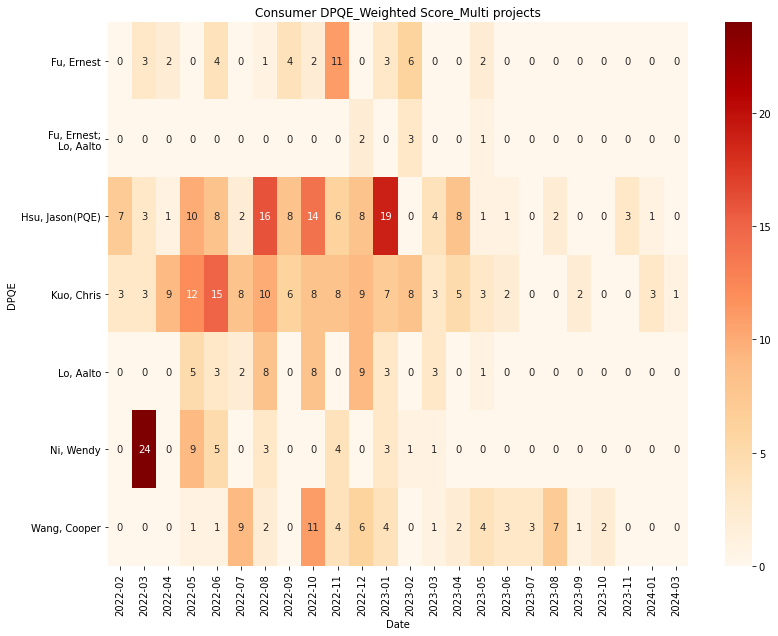

In [111]:
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).sum()['weighted_score_multi projects'].unstack(fill_value=0),cmap="OrRd", annot=True).set(title='Consumer DPQE_Weighted Score_Multi projects');
#plt.savefig('Consumer DPQE',bbox_inches = "tight")

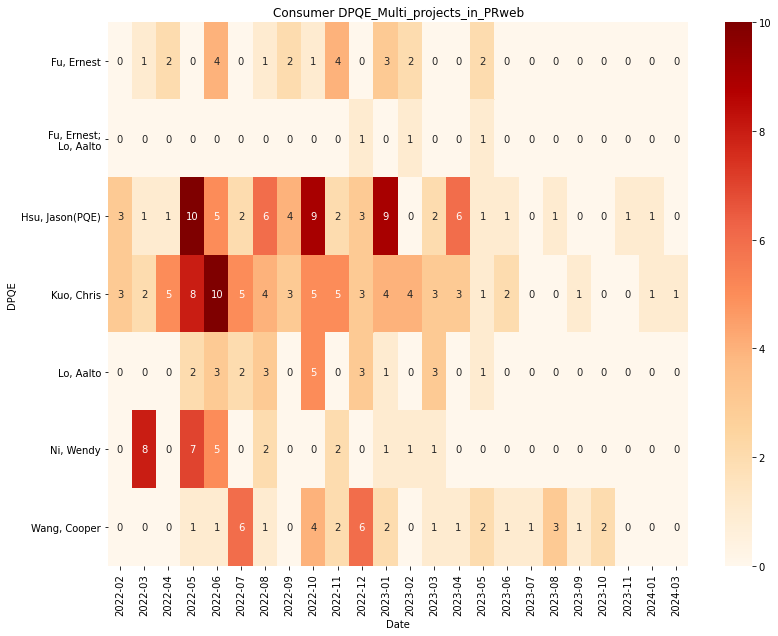

In [121]:
plt.figure(figsize=(13,10))
sns.heatmap(df_consumer_dpqe.groupby(['DPQE','Date']).sum()['Multi_Projects_in_PRweb'].unstack(fill_value=0),cmap="OrRd", annot=True).set(title='Consumer DPQE_Multi_projects_in_PRweb');

In [116]:
df_consumer_dpqe_project = df_consumer_dpqe.groupby(['DPQE','Date','Project Name']).sum().sort_index()
df_consumer_dpqe_project

Project ID  weighted_score  \
DPQE         Date    Project Name                                               
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs            15907               3   
             2022-04 2022 vivofit jr. 3 SKUs            15907               1   
                     Forerunner 955 and 955 Solar       12875               1   
             2022-06 Forerunner 255 Small               15830               1   
                     Forerunner 265                     14529               1   
...                                                       ...             ...   
Wang, Cooper 2023-07 Descent Mk3s                       16205               3   
             2023-08 Descent Mk3                        12994               3   
                     Enduro 2023                        14704               1   
             2023-09 Descent Mk3s                       16205               1   
             2023-10 Descent Mk3                        12994               1   

                                                   PM Project Id  \
DPQE         Date    Project Name                                  
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                 0.0   
             2022-04 2022 vivofit jr. 3 SKUs                 0.0   
                     Forerunner 955 and 955 Solar            0.0   
             2022-06 Forerunner 255 Small                    0.0   
                     Forerunner 265                      14529.0   
...                                                          ...   
Wang, Cooper 2023-07 Descent Mk3s                            0.0   
             2023-08 Descent Mk3                         12994.0   
                     Enduro 2023                             0.0   
             2023-09 Descent Mk3s                            0.0   
             2023-10 Descent Mk3                         12994.0   

                                                   Multi_Projects_in_PRweb  \
DPQE         Date    Project Name                                            
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                           1.0   
             2022-04 2022 vivofit jr. 3 SKUs                           1.0   
                     Forerunner 955 and 955 Solar                      1.0   
             2022-06 Forerunner 255 Small                              1.0   
                     Forerunner 265                                    2.0   
...                                                                    ...   
Wang, Cooper 2023-07 Descent Mk3s                                      1.0   
             2023-08 Descent Mk3                                       2.0   
                     Enduro 2023                                       1.0   
             2023-09 Descent Mk3s                                      1.0   
             2023-10 Descent Mk3                                       2.0   

                                                   weighted_score_multi projects  
DPQE         Date    Project Name                                                 
Fu, Ernest   2022-03 2022 vivofit jr. 3 SKUs                                 3.0  
             2022-04 2022 vivofit jr. 3 SKUs                                 1.0  
                     Forerunner 955 and 955 Solar                            1.0  
             2022-06 Forerunner 255 Small                                    1.0  
                     Forerunner 265                                          2.0  
...                                                                          ...  
Wang, Cooper 2023-07 Descent Mk3s                                            3.0  
             2023-08 Descent Mk3                                             6.0  
                     Enduro 2023                                             1.0  
             2023-09 Descent Mk3s                                            1.0  
             2023-10 Descent Mk3                                             2.0  

[193 rows x 5 col

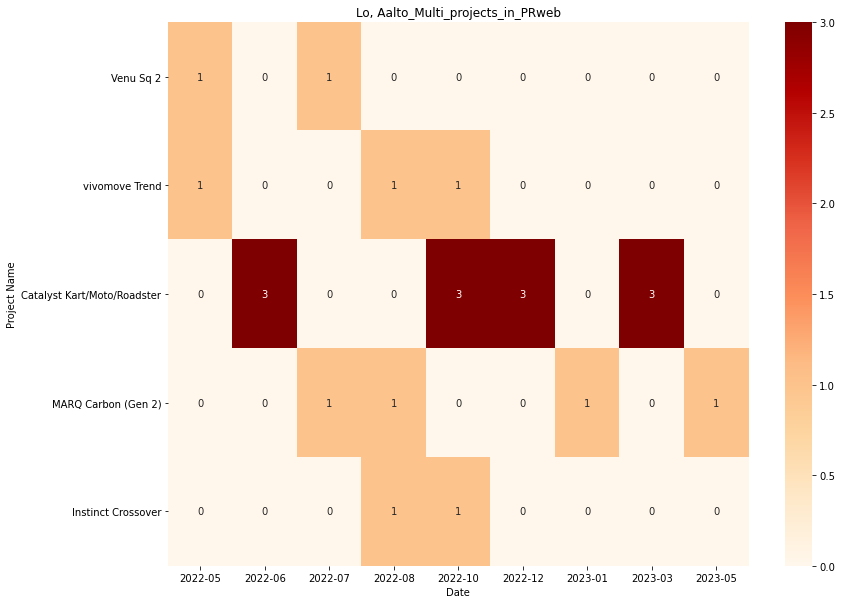

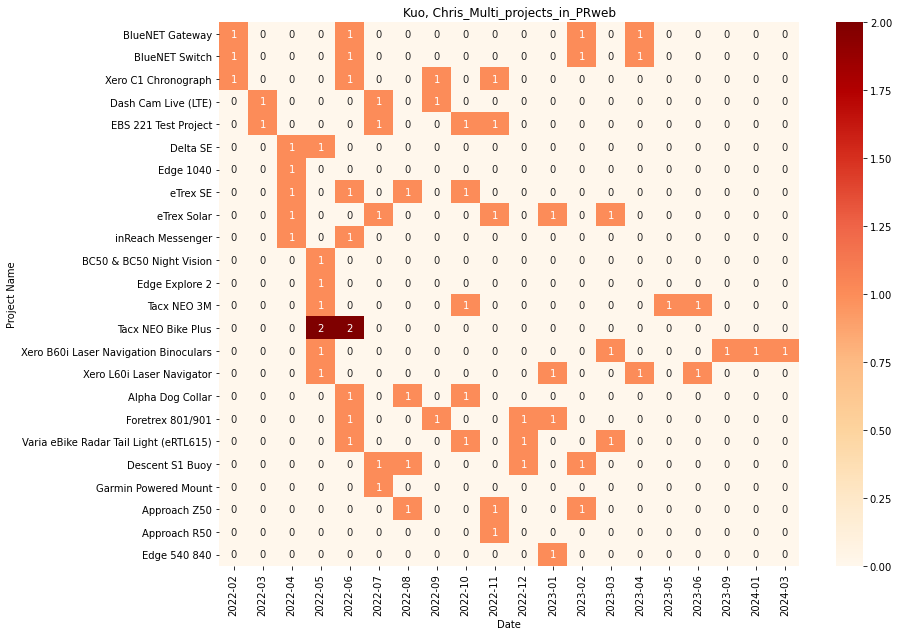

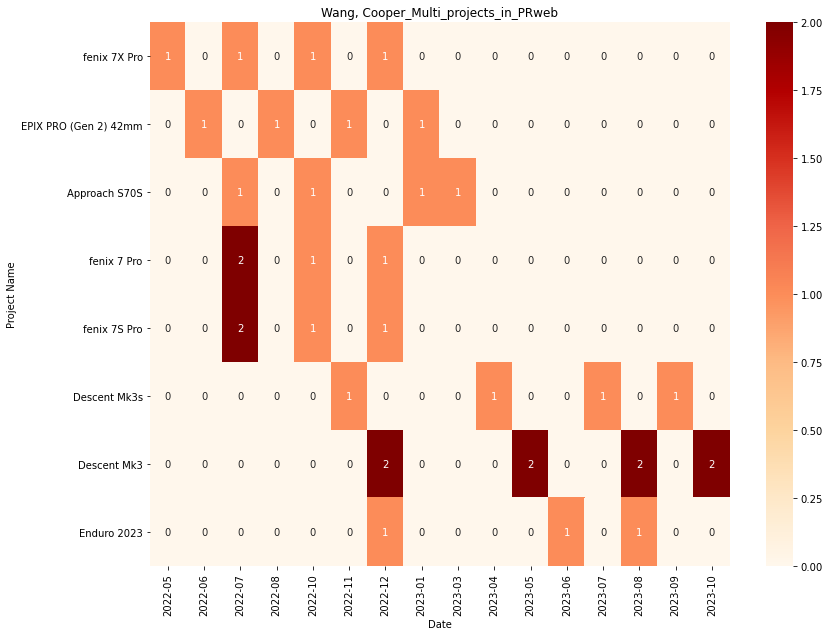

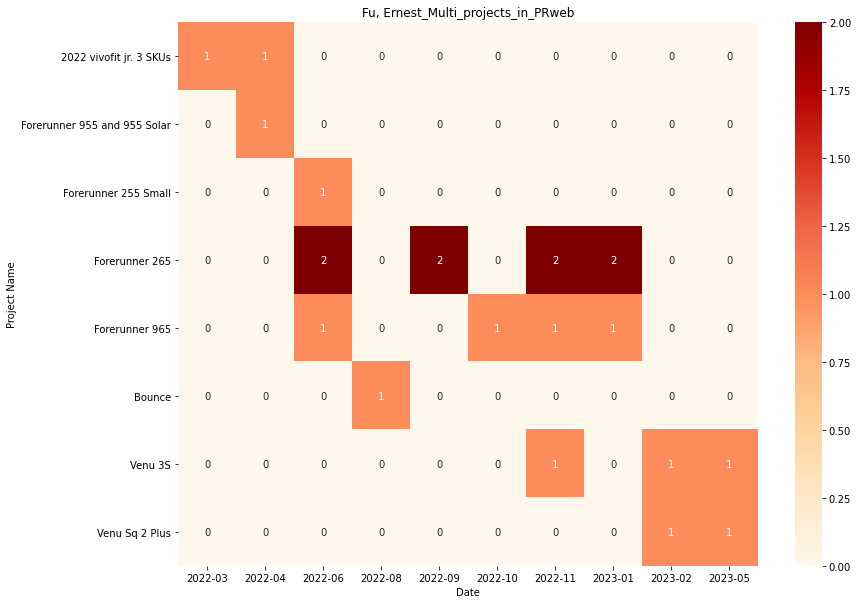

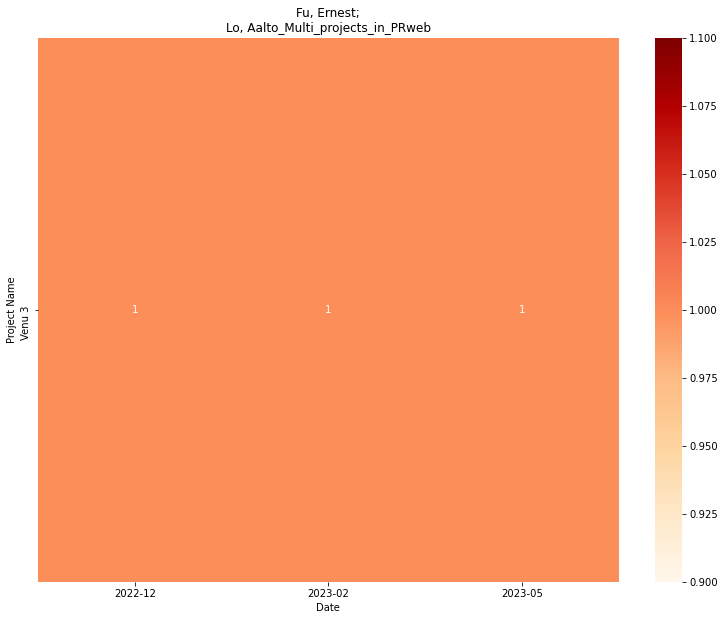

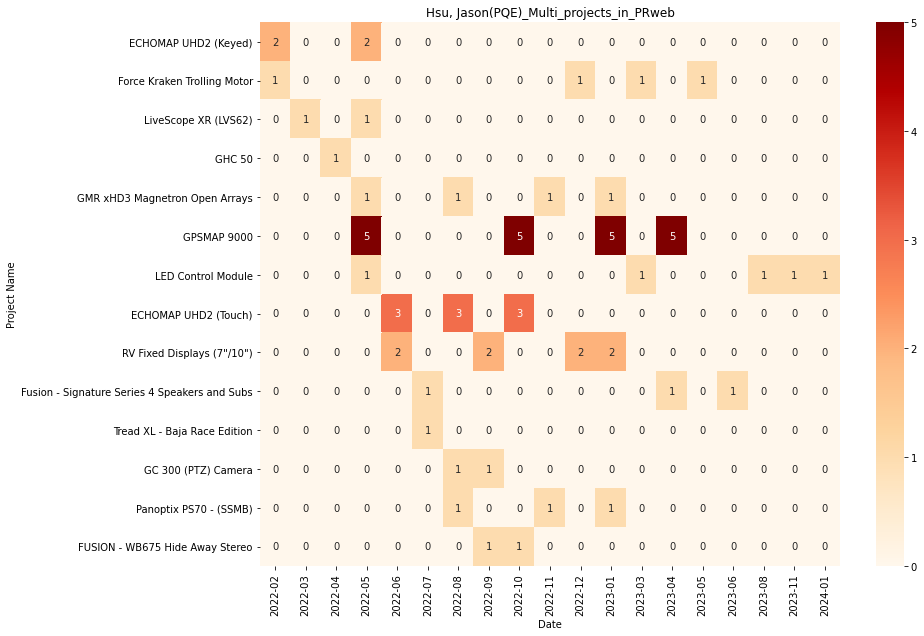

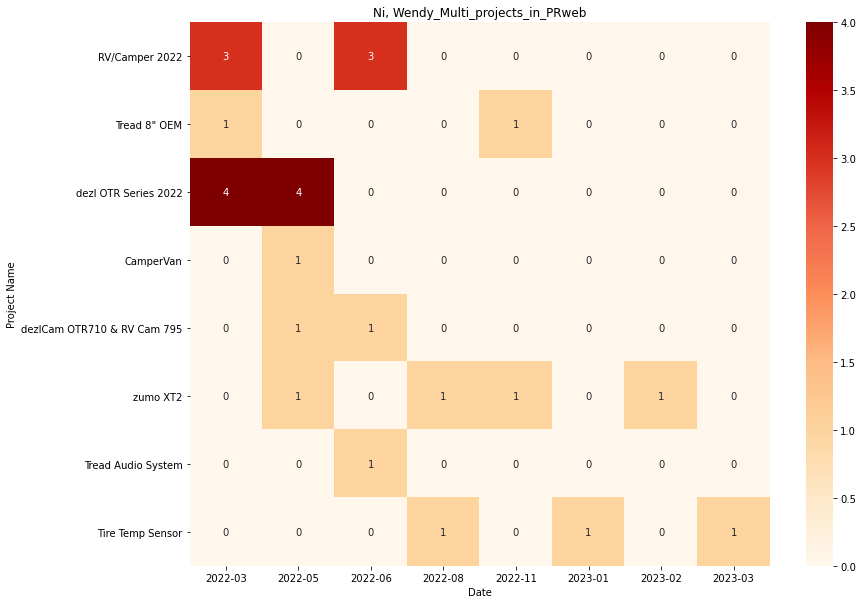

In [120]:
for member in consumer_dpqe_list:
    plt.figure(figsize=(13,10))
    sns.heatmap(df_consumer_dpqe_project.loc[member]['Multi_Projects_in_PRweb'].unstack(fill_value=0,level=0),cmap="OrRd", annot=True).set(title=member+'_Multi_projects_in_PRweb');

In [180]:
#plt.figure(figsize=(20,30))
#sns.heatmap(df_consumer_dpqe_project.unstack(level=1)['weighted_score'],cmap="OrRd", annot=True,linewidths=0.5, linecolor='orange');

In [181]:
#df_consumer_dpqe_project.unstack(level=1)['weighted_score'].to_excel('overall.xlsx')